### LONG SHORT TERM MEMORY NEURAL NETWORK

In [1]:
# Import required libraries
from tqdm import tqdm_notebook,tqdm
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import os
import platform

Using TensorFlow backend.


##### REQUIRED FUNCTIONS

In [2]:
def load_bergen_data(years = ['2013','2014','2015','2016','2017']):
    file_name_1 = 'elspot-prices_'
    file_name_2 = '_hourly_dkk.csv'
    if platform.system()=='Linux':
        data_folder = os.getcwd().replace('notebook','data/')
    else:
        data_folder = os.getcwd().replace('notebook','data\\')
    
    all_data=[]
    for year in years:
        file_name_tot = data_folder + file_name_1 + year + file_name_2
        all_data.append(pd.read_csv(file_name_tot,encoding = "ISO-8859-1",sep=';',decimal=','))
    df = pd.concat(all_data, ignore_index=True,sort= True)
    df = df[['datetime','Hours','Bergen']]
    return df

In [3]:
def generate_shifted_features(df,time_shift,colname):
    pd.options.mode.chained_assignment = None
    df = df[['datetime','Hours','Bergen']]
    for t in time_shift:
        df.loc[:,colname+'_'+str(t)] = df.Bergen.shift(t)
    return df

In [4]:
def create_train_test(df,test_size = 8000):
    df = df.dropna()
    train_size = df.shape[0]-test_size
    
    X_train = df.drop(['Bergen','Hours','datetime'],axis=1).head(train_size)
    y_train = df['Bergen'].head(train_size)
    X_test = df.drop(['Bergen','Hours','datetime'],axis=1).tail(test_size)
    y_test = df['Bergen'].tail(test_size)
    
    return X_train, y_train, X_test, y_test

In [5]:
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    #df = df.dropna()
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history.iloc[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def split_features_label(dataset):
    features, label = dataset[:, 0:-1], dataset[:, -1]
    features = features.reshape(features.shape[0], 1, features.shape[1])
    return features,label

# fit an LSTM network to training data
def fit_lstm(train, val, batch_size, nb_epoch, neurons):
    X, y = split_features_label(train)
    X_val, y_val = split_features_label(val)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in tqdm_notebook(range(nb_epoch)):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, validation_data=(X_val,y_val))
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


### LSTM MODEL

In [6]:
# model parameters
n_features = 24 # how many time steps to consider for the analysis
time_interval = 1 # how many hour in advance the modell should make the prediction

# internal paramters for the LSTM model
n_shift = n_features + time_interval - 1
n_ahead = range(0,time_interval)

In [7]:
# data loading and feature extraction
df = load_bergen_data()
raw_values = df['Bergen'].dropna()
diff_values = difference(raw_values, interval = time_interval)
supervised = timeseries_to_supervised(diff_values, n_shift)
supervised_values = supervised.values

In [8]:
# train - validation split
validation_share = 0.20
test_size = round(validation_share*supervised_values.shape[0])
train_size = supervised_values.shape[0]-test_size
train, test = supervised_values[0:train_size,:], supervised_values[train_size:,:]
if len(n_ahead)>0:
    train, test = np.delete(train, n_ahead, axis = 1),np.delete(test, n_ahead, axis = 1)

In [9]:
# feature scaling
scaler, train_scaled, test_scaled = scale(train, test)

In [10]:
# fit the model
lstm_model = fit_lstm(train_scaled,test_scaled, 1, 5, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
#lstm_model.predict(train_reshaped, batch_size=1)

#### MODEL PERFORMANCE 

In [11]:
# walk-forward validation on the test data
predictions = list()
n_lag = n_shift 
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values.iloc[len(train) + i + 1]

In [12]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-test_size:], predictions))
mae = mean_absolute_error(raw_values[-test_size:], predictions)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 10.144
Test MAE: 3.986


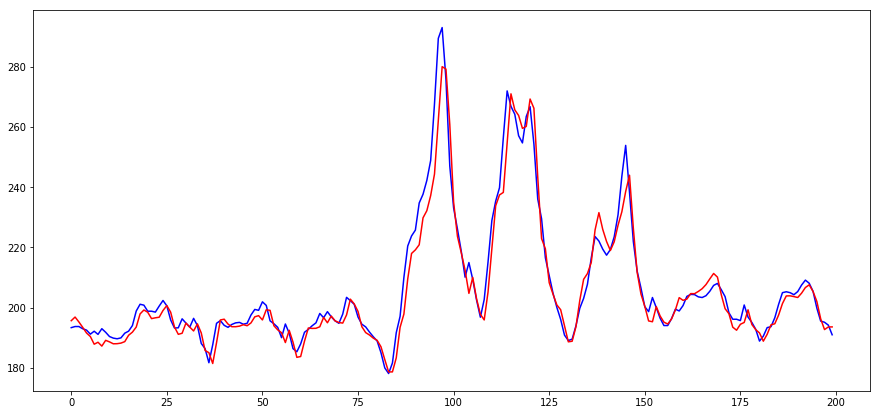

In [13]:
# line plot of observed vs predicted
pyplot.figure(figsize=(15,7))
subset= 200
pyplot.plot(range(subset),raw_values[-subset:],color = 'b')
pyplot.plot(range(subset),predictions[-subset:], color = 'r')
pyplot.show()